# Generate the Ground Truth Overlap
The file to generate ground truth overlaps which used in training and validation.

Note, before running this file, please make sure the following files are ready:

   * overlaps.bin: the overlap matrix that contains the overlap between each pair of scans.
   * poses.txt: the positions of each scan (for visualization).

In [174]:
import os
import yaml
import tqdm
import numpy as np
import matplotlib.pyplot as plt

from normalize_data import normalize_data
from tools.fileloader import load_xyz_rot, load_overlaps
from tools.training_tools import splitting

# auto-reload external modules
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Configuration
Modify the configuration in *config/gen_gt_overlap.yml*.

In [175]:
# load config file
config_path = '/home/vectr/PycharmProjects/lidar_learning/data/kitti/dataset/config_kitti.yml'
config = yaml.safe_load(open(config_path))

data_root = config['data_root']
sequences = config['sequences']
sequence = sequences[21]

overlaps_matrix_path = os.path.join(data_root, sequence, 'overlaps/overlaps.bin')  # the overlaps matrix in shape (num_scans, num_scans)
overlaps_batch_path = os.path.join(data_root, sequence, 'overlaps')                # the folder to save the overlaps list (overlaps_batch.npy)
poses_path = os.path.join(data_root, sequence, 'poses/poses.txt')                  # file of poses in global frame


## Generate Overlap and Yaw Ground Truth Array

In [176]:
overlaps_matrix = load_overlaps(overlaps_matrix_path)
print(f'Matrix shape: {overlaps_matrix.shape}.')

xyz, _ = load_xyz_rot(poses_path)
print(f'Positions shape: {xyz.shape}.')


Matrix shape: (2721, 2721).
Positions shape: (2721, 3).


## Visualize the Overlaps Matrix

In [177]:
# "00": 0.30,
overlap_thresh = 0.30

%matplotlib qt
num_scans = xyz.shape[0]
for i in tqdm.tqdm(range(num_scans)):
    overlaps_i = overlaps_matrix[i, :]
    xyz_pos_i = xyz[overlaps_i >= overlap_thresh, :]
    xyz_neg_i = xyz[overlaps_i < overlap_thresh, :]

    plt.clf()
    plt.scatter(xyz[:, 0], xyz[:, 1], c='b', label='trajectory')
    plt.scatter(xyz_pos_i[:, 0], xyz_pos_i[:, 1], c='y', label='positive')
    plt.scatter(xyz[i, 0], xyz[i, 1], c='g', label=f'scan {i+1}')
    plt.legend()
    plt.show()
    plt.pause(0.001)


## Reformat Overlaps Matrix (to n^2 * 4 Table)
Reformat the overlaps matrix to a table with shape (n^2, 4), where n is the number of scans.

In [178]:
# save overlaps information in a table, col0: source scan path, col1: reference scan path, col2: overlap between source and reference scans, col3: overlap threshold
num_scans = xyz.shape[0]
overlaps = []
overlaps_table = np.empty((num_scans**2, 4))

for i in tqdm.tqdm(range(num_scans)):
    overlaps_i = np.zeros((num_scans, 4))
    overlaps_i[:, 0] = np.ones(num_scans, dtype=int) * i
    overlaps_i[:, 1] = np.arange(num_scans, dtype=int)
    overlaps_i[:, 2] = overlaps_matrix[i, :]
    overlaps_i[:, 3] = np.ones(num_scans, dtype=float) * overlap_thresh
    overlaps.append(overlaps_i)
    overlaps_table[num_scans*i:num_scans*(i+1), :] = overlaps_i

print(f'Number of pairs: {overlaps_table.shape}')


100%|██████████| 2721/2721 [00:00<00:00, 21106.61it/s]

Number of pairs: (7403841, 4)


## Histogram of Overlaps Distribution 
Plot the histogram which is used to normalize the dataset.

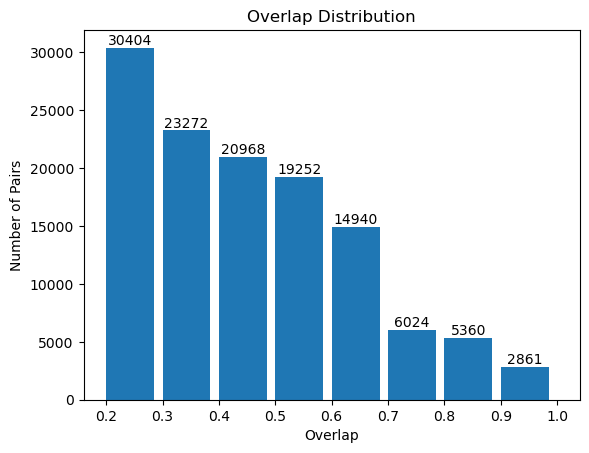

In [179]:
%matplotlib inline

# only show tail bins
min_overlap_show = 0.2
max_overlap_show = 1.0
overlaps = overlaps_table[:,2]

_, _, patches = plt.hist(overlaps[(overlaps <= max_overlap_show) & (overlaps >= min_overlap_show)], int((max_overlap_show-min_overlap_show)/0.1), width=0.085)
plt.bar_label(patches)
plt.title('Overlap Distribution')
plt.xlabel('Overlap')
plt.ylabel('Number of Pairs')
plt.show()


## Normalize Overlaps Distribution
We need balance the number of positive and negative data pairs for training. Moreover, we can control the number of pairs to adjust the training time.

100%|██████████| 2721/2721 [00:01<00:00, 1978.35it/s]


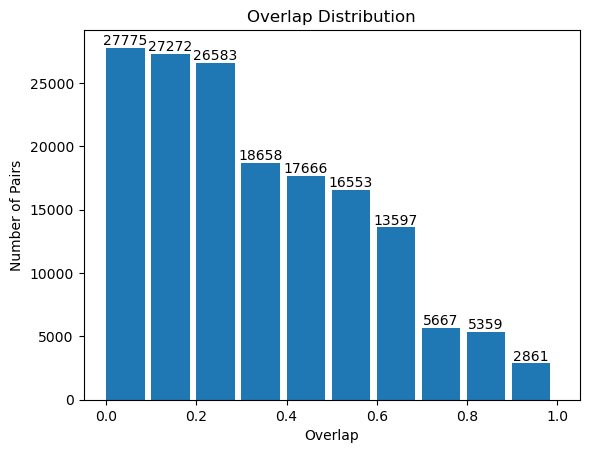

Overlaps_table_normalized shape: (161991, 4)
Number of positive pairs: 80361.
Number of negative pairs: 81630.
Select 2.19% data
Average 29.53 positive data per frame
Average 30.00 negative data per frame


In [180]:
neg_pos_threshold = round(overlap_thresh / 0.1)
max_num_pos_each_scan = 30  # if yaw_enhance is True, the number of positive pairs will be a little larger than the max_num_pos_each_scan
min_num_neg_each_scan = 10   # make sure to roughly balance the number of positive and negative pairs

overlaps_table_normalized, pos_indices, neg_indices = normalize_data(overlaps_table, max_pos_thresh=max_num_pos_each_scan, min_neg_thresh=min_num_neg_each_scan, neg_pos_threshold=neg_pos_threshold, enhance_yaw=True)
overlaps_normalized = overlaps_table_normalized[:,2]
_, _, patches = plt.hist(overlaps_normalized, 10, width=0.085)
plt.bar_label(patches)
plt.title('Overlap Distribution')
plt.xlabel('Overlap')
plt.ylabel('Number of Pairs')
plt.show()

percent_keep = format(len(overlaps_table_normalized) / len(overlaps_table) * 100, ".2f")
num_pos = np.sum(overlaps_normalized >= neg_pos_threshold / 10)
num_neg = np.sum(overlaps_normalized < neg_pos_threshold / 10)

print(f"Overlaps_table_normalized shape: {overlaps_table_normalized.shape}")
print(f"Number of positive pairs: {num_pos}.")
print(f"Number of negative pairs: {num_neg}.")
print(f"Select {percent_keep}% data")
print(f"Average {num_pos / np.sqrt(len(overlaps_table)):.2f} positive data per frame")
print(f"Average {num_neg / np.sqrt(len(overlaps)):.2f} negative data per frame")

## Generate Dataset Used for Training, Validation, and Testing 
Format the data in table to load data efficiently.

max_num_pos = 100, max_num_neg = 100 \
col0: curr_scan_id \
col1: sequence \
col2: overlap_threshold \
col3: num_pos \
col4: num_neg \
col5-104: pos_ids \
col105-204: neg_ids \
(add overlaps in col205:404 if needed)


In [181]:
# matrix shape: (num_scans, 5+max_num_pos+max_num_neg(+max_num_pos+max_num_neg))
overlaps_batch = (-np.ones((num_scans, 405))).astype(object)

# save positive and negative pairs for full dataset
overlaps_batch[:, 0] = np.arange(num_scans)          # scan i (int)
overlaps_batch[:, 1] = sequence                      # sequence (string)
overlaps_batch[:, 2] = overlap_thresh                # overlap threshold (float)
overlaps_batch[:, 3] = 0                             # number of positive pairs (int)
overlaps_batch[:, 4] = 0                             # number of negative pairs (int)

for i in range(overlaps_table_normalized.shape[0]):
    curr_id = int(overlaps_table_normalized[i, 0])
    ref_id = int(overlaps_table_normalized[i, 1])
    overlap = overlaps_table_normalized[i, 2]
    
    if overlap >= overlap_thresh:
        overlaps_batch[curr_id, overlaps_batch[curr_id, 3] + 5] = ref_id
        overlaps_batch[curr_id, overlaps_batch[curr_id, 3] + 205] = overlap
        overlaps_batch[curr_id, 3] += 1
    else:
        overlaps_batch[curr_id, overlaps_batch[curr_id, 4] + 105] = ref_id
        overlaps_batch[curr_id, overlaps_batch[curr_id, 4] + 305] = overlap
        overlaps_batch[curr_id, 4] += 1

np.savez(os.path.join(overlaps_batch_path, 'overlaps_batch'), overlaps=overlaps_batch)


## Visualize Generate Dataset (Option)
Visualize the generated overlaps for a frame.

In [182]:
%matplotlib qt
num_scans = xyz.shape[0]
for i in tqdm.tqdm(range(num_scans)):
    overlaps_i = overlaps_matrix[i, :]
    curr_pos_indices = pos_indices[i]
    curr_neg_indices = neg_indices[i]
    xyz_curr_pos = xyz[curr_pos_indices, :]
    xyz_curr_neg = xyz[curr_neg_indices, :]

    plt.clf()
    plt.scatter(xyz[:, 0], xyz[:, 1], c='b', label='trajectory')
    plt.scatter(xyz_curr_pos[:, 0], xyz_curr_pos[:, 1], c='y', label='positive')
    plt.scatter(xyz_curr_neg[:, 0], xyz_curr_neg[:, 1], c='r', label='negative')
    plt.scatter(xyz[i, 0], xyz[i, 1], c='g', label=f'scan {i+1}')
    plt.legend()
    plt.show()
    plt.pause(0.001)